In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import pandas as pd
from skimage.morphology import square
from skimage.measure import label, regionprops
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from skimage.filters import threshold_otsu
import skimage.io
import skimage.filters
import skimage.measure

#Show the actual image from an image matrix
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

#To read an image:
#go to the files icon on the left toolbar, press "Upload to session storage" and select the image so it is in the session
def read_image(filename):
    image = plt.imread(filename)

# 1- Creating a labeled binary for 7x7 squares

In [2]:
#Define each colony as a distinct "object"
def connected_components(filename, connectivity=2):
    # load the image
    image = skimage.io.imread(filename)
    #Crop the image
    image=np.delete(image,range(950,1017),0)
    image=np.delete(image,range(0,75),0)
    image=np.delete(image,range(1400,1432),1)
    image=np.delete(image,range(0,90),1)
    #blur the image
    image = skimage.filters.gaussian(image, sigma=7, truncate=8, multichannel=True)
    # make an inverted binary
    thresh = threshold_otsu(image)
    binary = image > thresh
    binary_mask=np.invert(binary)
    #Set the minimum area of an object to 2 pixels (python was picking up 1-pixel objects when I first tried it)
    mask = skimage.morphology.remove_small_objects(binary_mask,1000)
    # perform connected component analysis (count=number of objects)
    labeled_image, count = skimage.measure.label(mask,
                                                 connectivity=connectivity, return_num=True)
    regions=regionprops(labeled_image)
    return labeled_image, count, regions, mask

#labeled_image is a matrix where each object is numbered 1-96 (the background is 0)
#count is the number of objects there are (numbered 1-96 if there are 96 objects)
#regions group the individual object properties
#mask is the binary mask from which objects were found (a matrix of 1s and 0s)

In [3]:
#Finad and label objects in the original JB50 7x7 plate
labeled_image,count,regions,mask=connected_components("20220627_1_biofilm_JB50_7x7.jpg")

#Name each object after its position (A1-H12)
def number_plate(regions):
  x_array=[]
  y_array=[]
  for r in regions:
    x,y=r["centroid"]
    x_array.append(x)
    y_array.append(y)
  rows=pd.cut(x_array,8, labels=["A","B","C","D","E","F","G","H"])
  cols=pd.cut(y_array,12, labels=["1","2","3","4","5","6","7","8","9","10","11","12"])
  index=[]
  for i in range(0,len(rows)):
    index.append(rows[i]+cols[i])
  d = {'x': x_array, 'y': y_array, "row": rows, "col":cols, "index": index}
  df = pd.DataFrame(data=d)
  return df

#Show the dataframe of x (vertical) and y (horizontal) coordinates of the centroid of each object
df=number_plate(regions)
df

,x,y,row,col,index
0,67.301153,1238.426644,A,12,A12
1,68.959430,67.807563,A,1,A1
2,68.592676,918.024454,A,9,A9
3,68.322318,1024.470146,A,10,A10
4,68.048521,1131.133776,A,11,A11
...,...,...,...,...,...
91,806.670896,814.070971,H,8,H8
92,808.022730,390.687141,H,4,H4
93,807.753544,496.342485,H,5,H5
94,809.223356,284.224777,H,3,H3


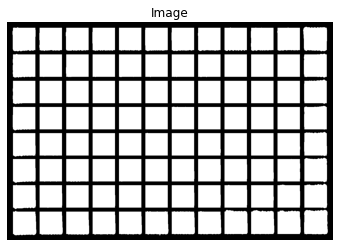

In [4]:
#Make a new binary where the centroid of each square is the average of the centroids on the side of the plate
#Eg centroid of D4 is: x=average x of D1 and D12, y=average y of A4 and H4
#Make each square in the binary 90x90 pixels
m=mask
for ind in df["index"]:
  i=df[df['index']==ind].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=round(x-45)
  minc=round(y-45)
  maxr=round(x+45)
  maxc=round(y+45)
  m[minr:maxr,minc:maxc]=square(90)

show_image(m)

In [5]:
#Find and label objects in the new binary
labeled_image, count = skimage.measure.label(m,connectivity=2, return_num=True)
regions=regionprops(labeled_image)

#Return a dataframe of x and y coordinates of object centroids
df=number_plate(regions)

#Make a dictionary of each plate number
plate={}
n=0
for r in range(0,len(regions)):
  n=df.iat[r,2]+df.iat[r,3]
  plate[n]=regions[r]

# 2- Using the binary for image processing

In [ ]:
#Import an image to be analysed
image = skimage.io.imread("20220627_1_biofilm_lib_7x7.jpg")
#Crop the image
image=np.delete(image,range(950,1017),0)
image=np.delete(image,range(0,75),0)
image=np.delete(image,range(1400,1432),1)
image=np.delete(image,range(0,90),1)
image=np.invert(image)

#Create a dictionary of mean intensity for each square for "image" from "labeled_image"
mean_intensities={}
for i in dict.keys(plate):
  m=np.mean(image[np.where(labeled_image==plate[i]["label"])])
  mean_intensities[i]=m
print(mean_intensities)

# Extra code

In [ ]:
#This is just to show the areas coloured in the improved binary but the red squares can't actually be used as a mask
fig, ax = plt.subplots()

image = skimage.io.imread("20220627_1_biofilm_JB50_7x7.jpg")
    #Crop the image
image=np.delete(image,range(950,1017),0)
image=np.delete(image,range(0,75),0)
image=np.delete(image,range(1400,1432),1)
image=np.delete(image,range(0,90),1)

show_image(image)
rect=[]
for p in plate:
  i=df[df['index']==p].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=x-45
  minc=y-45
  maxr=x+45
  maxc=y+45
  rect.append(mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2))

#can only do this once, the rect objects can't be reused on another plot?
for r in rect:
  ax.add_patch(r)

ax.set_axis_off()
plt.tight_layout()
plt.show()